# Plot Data Caulobacter crescentus fast imaging
 
In this notebook we plot the time-lapse data of Caulobacter crescentus mutant strains with cdg sensor growing on agar-pads imaged at high time resolution

---

## Import packages

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

---

## Setup Folders & Load Data

In [3]:
image_dir = pathlib.Path() / 'images'
data_dir = pathlib.Path() / 'data_files'

df_name = data_dir / 'filtered_data_Cc_Fast.csv'
df = pd.read_csv(df_name, index_col=0)

frm_interval = 20/60 #frame interval in minutes
df['time since birth [min]'] = df['age'] * frm_interval

print(f"n={df['uni_id'].unique().size}")

n=224


## Add cdg treshhold

We set manual cdg-threshold based on visual inspection of histogram to group cells in cdg high and cdg low cells.

We also add filter "ok_cell" that indicates if cells start in CDG high state (which they all should)

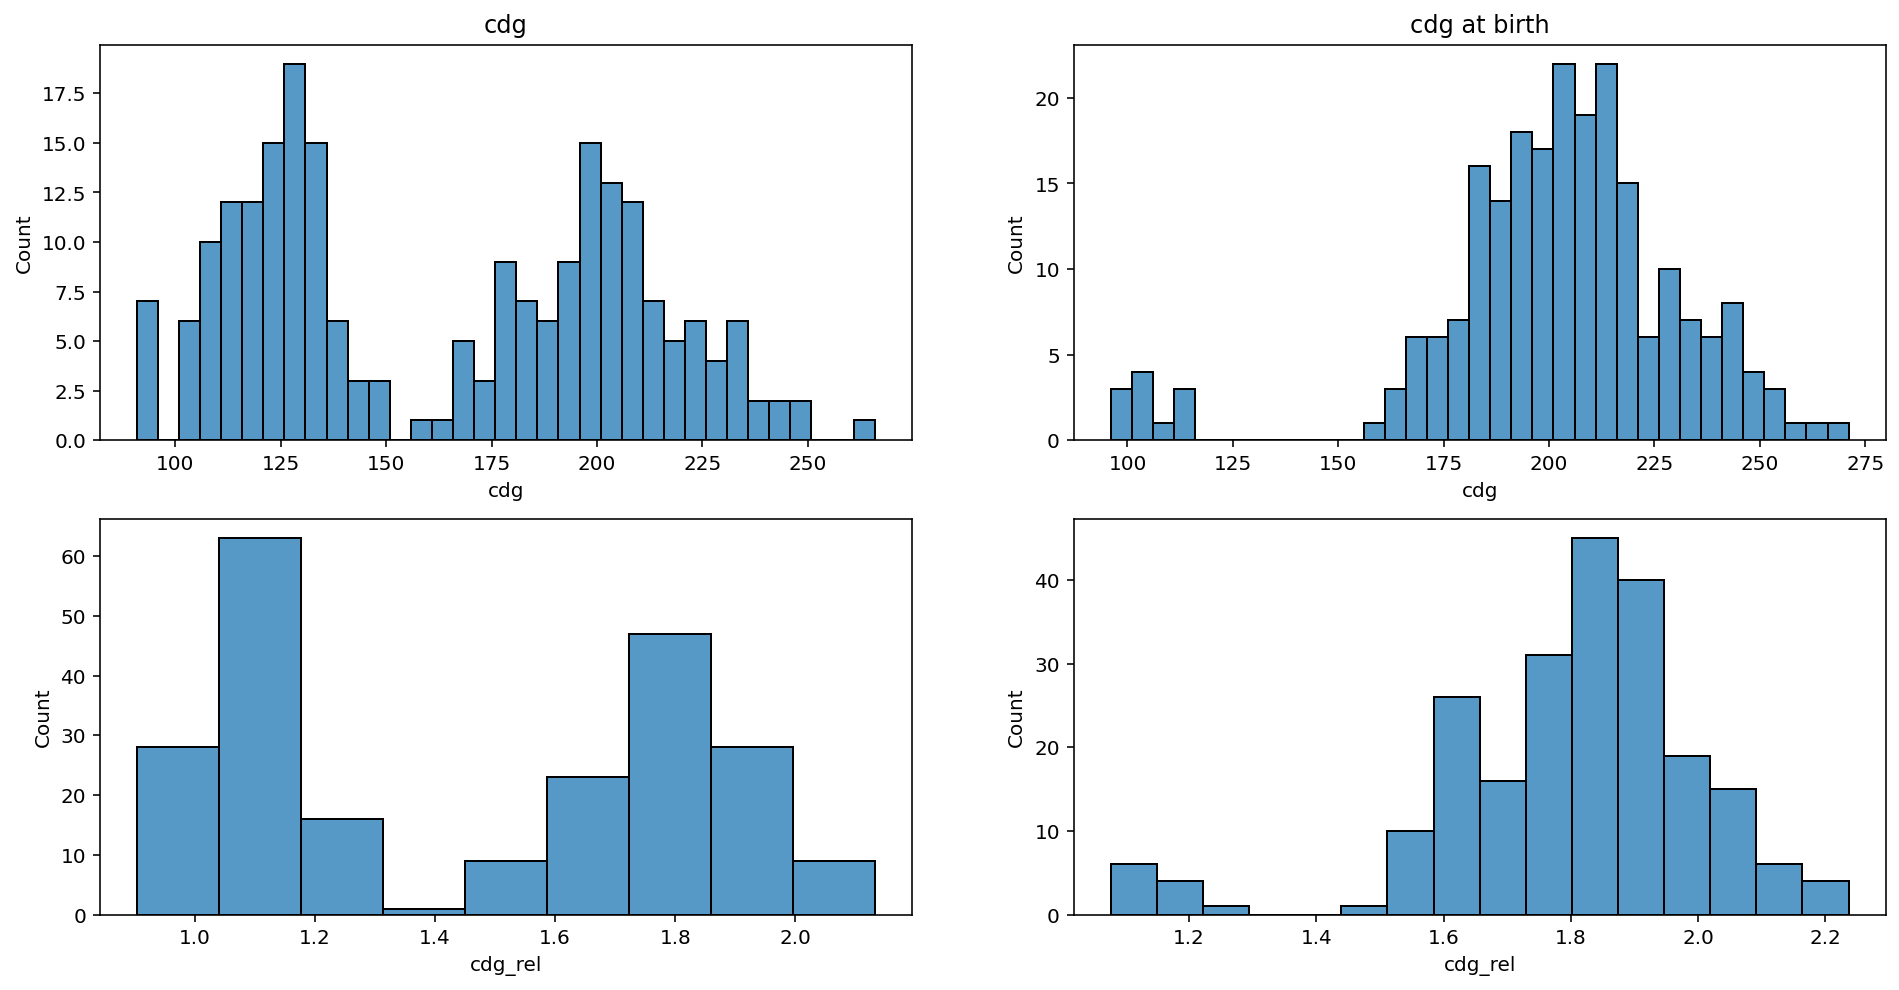

In [4]:
#plot distribution of cdg and cdg_rel
fig, axs = plt.subplots(2,2,figsize=(16,8))
sns.histplot(data=df.groupby('uni_id').min(), x='cdg', ax=axs[0,0], binwidth=5).set_title('cdg')
sns.histplot(data=df[df['age']==0], x='cdg', ax=axs[0,1], binwidth=5).set_title('cdg at birth')

sns.histplot(data=df.groupby('uni_id').min(), x='cdg_rel', ax=axs[1,0])
sns.histplot(data=df[df['age']==0], x='cdg_rel', ax=axs[1,1])

#set cdg and cdg_rel thresholds
cdg_tresh = 150
cdg_rel_tresh = 1.4

#add columns to df
df['cdg_type'] = df.groupby('uni_id')['cdg'].transform(lambda x: 'high' if np.min(x) > cdg_tresh else 'low' )
df['ok_cell'] = df.groupby('uni_id')['cdg'].transform(lambda x: True if x.iloc[0]>cdg_tresh else False )
df['cdg_rel_type'] = df.groupby('uni_id')['cdg_rel'].transform(lambda x: 'high' if np.min(x) > cdg_rel_tresh else 'low' )
df['ok_rel_cell'] = df.groupby('uni_id')['cdg_rel'].transform(lambda x: True if x.iloc[0]>cdg_rel_tresh else False )

## Calculate change in time in CDG levels

We now calculate derivatives of cdg levels

In [5]:
#add cdg production rate
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

def calc_promoter_activity(df, channel, fit_window=5, frm_interval=1, gamma=0.0015):
    min_periods = int(np.ceil(fit_window/2))
    
    ddt_fluor = df.groupby('uni_id')[channel].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval}).reset_index(0,drop=True)
    return (gamma + df['elongation_rate'] ) * df[channel] + ddt_fluor   

def calc_ddt(df, channel, fit_window=5, frm_interval=1, gamma=0.0015):
    min_periods = int(np.ceil(fit_window/2))
    ddt_fluor = df.groupby('uni_id')[channel].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval}).reset_index(0,drop=True)
    return ddt_fluor   


def calc_elengation_rate(df, lengthname='length', fit_window=5, frm_interval=1):
    min_periods = int(np.ceil(fit_window/2))
    return df.groupby('uni_id')['length'].rolling(fit_window, min_periods=min_periods, center=True).apply(derivative, kwargs={'frm_interval':frm_interval, 'log':True}).reset_index(0,drop=True)


def calc_smooth(df, field, fit_window=5):
    min_periods = int(np.ceil(fit_window/2))
    return df.groupby('uni_id')[field].rolling(fit_window, min_periods=min_periods, center=True).apply(lambda x: x.mean()).reset_index(0,drop=True)

df['elongation_rate'] = calc_elengation_rate(df, fit_window=7, frm_interval=frm_interval)
df['ddt_cdg'] = calc_ddt(df, 'fluo1', fit_window=7, frm_interval=frm_interval)
df['cdg_smooth'] = calc_smooth(df, 'cdg', fit_window=5)

## Add time relative to peak of CDG expression

We add time relative to peak of cdg expression

In [6]:
df['age_of_peak'] = df.groupby('uni_id')['ddt_cdg'].transform(lambda x: np.argmax(x))
df['relative time [min]'] = (df['age'] - df['age_of_peak'])*frm_interval

df['age_of_val'] = df.groupby('uni_id')['cdg_smooth'].transform(lambda x: np.argmin(x))
df['relative time 2 [min]'] = (df['age'] - df['age_of_val'])*frm_interval

## Plot CDG dynamics

n_upper=213
n_lower=96


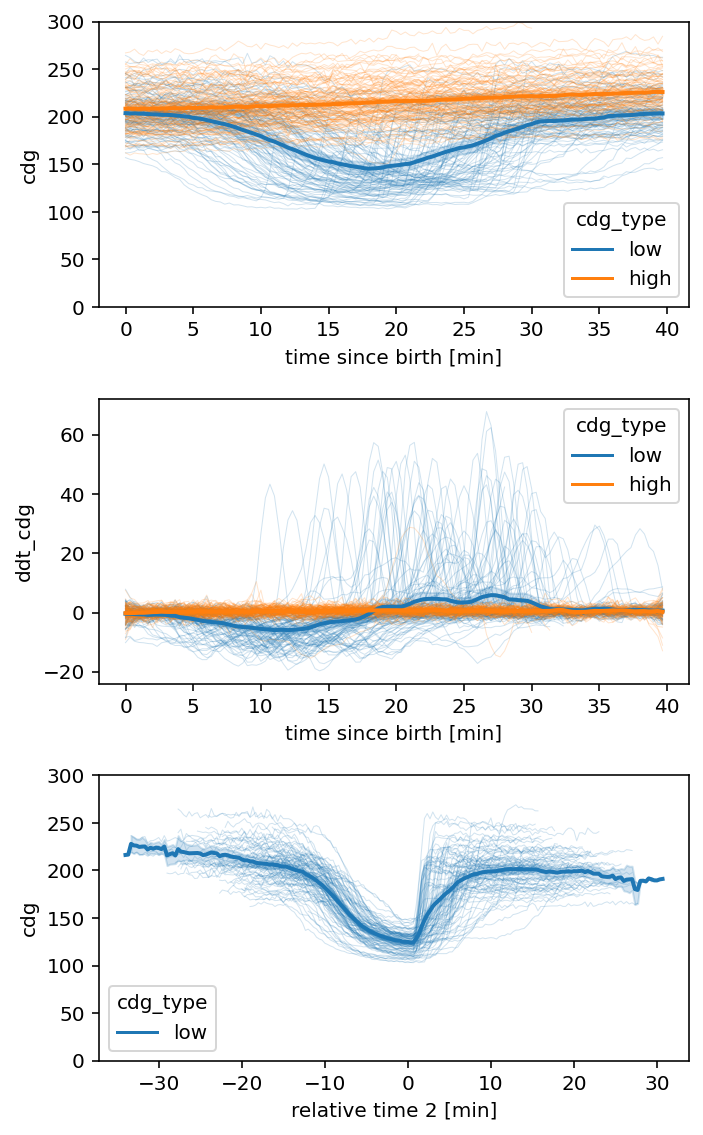

In [8]:

fig, axs = plt.subplots(3,1,figsize=(5,8))

#filter on cells that start with high cdg
data_fig0 = df[df['ok_cell']]
data_fig1 = df.loc[df['ok_cell'] & (df['cdg_type']=='low')]

sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig0, x='time since birth [min]', y='cdg', hue='cdg_type', 
             ax=axs[0], lw=2).set_ylim((0,300));


sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], units='uni_id', estimator=None, lw=0.5, legend=False, alpha=0.2);
sns.lineplot(data=data_fig0, x='time since birth [min]', y='ddt_cdg', hue='cdg_type', 
             ax=axs[1], lw=2);


sns.lineplot(data=data_fig1, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig1, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs[2], lw=2).set_ylim((0,300));

plt.tight_layout()

print(f"n_upper={data_fig0['uni_id'].unique().size}")
print(f"n_lower={data_fig1['uni_id'].unique().size}")

n=96


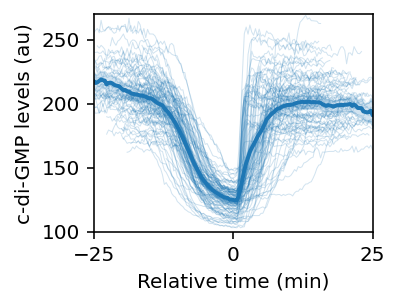

In [13]:
fig, axs = plt.subplots(1,1,figsize=(2.5,2))

#filter on cells that start with high cdg
data_fig = df.loc[df['ok_cell'] & (df['cdg_type']=='low')]
sns.lineplot(data=data_fig, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs, units='uni_id',estimator=None, lw=0.5, legend=False, alpha=0.2).set_ylim((0,300));
sns.lineplot(data=data_fig, x='relative time 2 [min]', y='cdg', hue='cdg_type', 
             ax=axs, lw=2).set_ylim((0,300));

axs.set_xlabel('Relative time (min)')
axs.set_ylabel('c-di-GMP levels (au)')

axs.set_ylim((100,270))
axs.set_yticks([100,150,200,250])

axs.set_xlim((-25,25))
axs.set_xticks([-25,0,25])

axs.legend().remove()  # Remove the legend

fig.savefig(image_dir / 'fig_3i.svg', bbox_inches='tight')

data_fig.to_csv(data_dir / 'source_data_fig_3i.csv')

print(f"n={data_fig['uni_id'].unique().size}")